# Importation

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp
import yaml

import qubic
from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps
from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene
from qubic.lib.Qsamplings import get_pointing, equ2gal, QubicSampling

from qubic.lib.MapMaking.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import MPI, BlockDiagonalOperator, DiagonalOperator, ReshapeOperator

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

# Atm class

In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

500


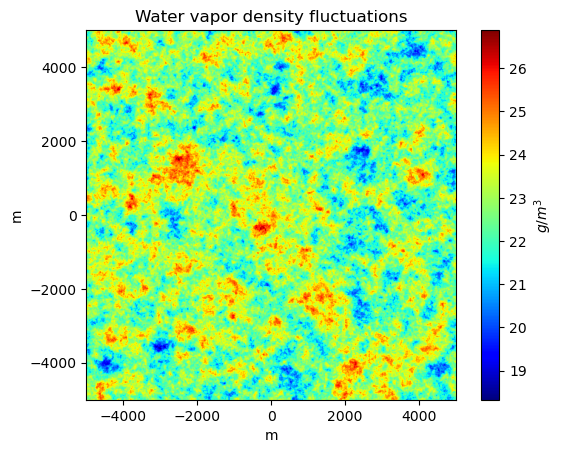

In [45]:
wv_fluctuations = atm.rho_map
print(wv_fluctuations.shape[0])
plt.imshow(wv_fluctuations, cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.title('Water vapor density fluctuations')
plt.xlabel('m')
plt.ylabel('m')
plt.colorbar(label=r'$g/m^{3}$')

In [38]:
print("Frequencies are : ", atm.frequencies, "GHz.")

Frequencies are :  [135.50540829 144.29216391 153.6486907  163.61193508 198.74126549
 211.62850707 225.35141303 239.96417145] GHz.


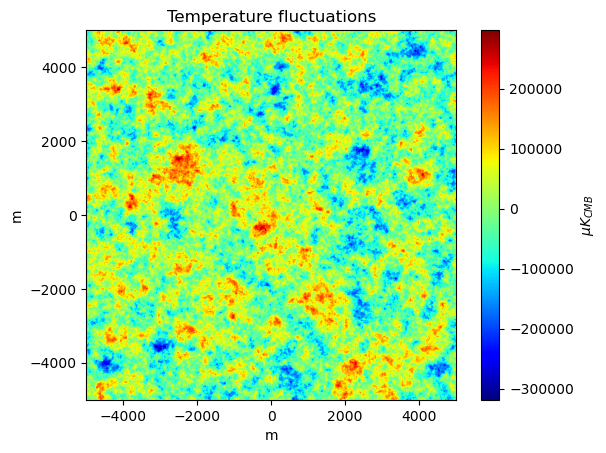

In [ ]:
temp_fluctuations = np.zeros((wv_fluctuations.shape[0], wv_fluctuations.shape[1], 3))
temp_fluctuations[..., 0] = atm.get_temp_maps(wv_fluctuations)[0]
temp_fluctuations[..., 0] -= np.mean(temp_fluctuations[..., 0])

plt.imshow(temp_fluctuations[..., 0], cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.title('Temperature fluctuations')
plt.xlabel('m')
plt.ylabel('m')
plt.colorbar(label=r'$\mu K_{CMB}$')

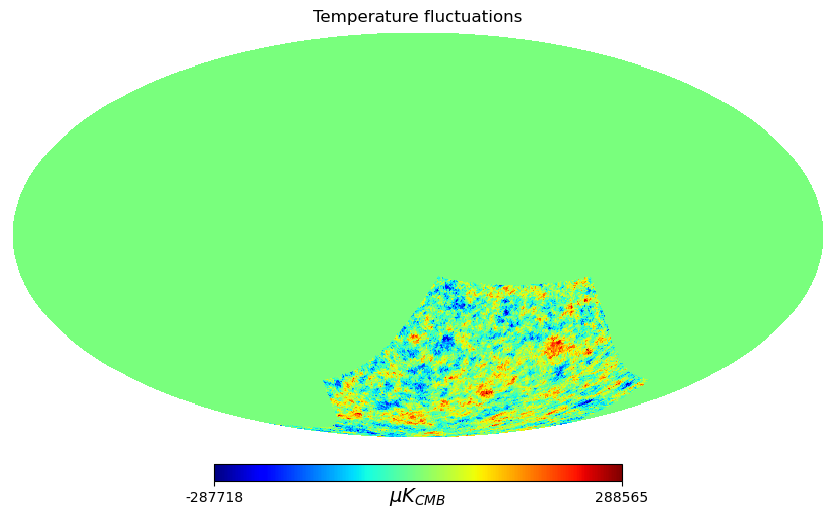

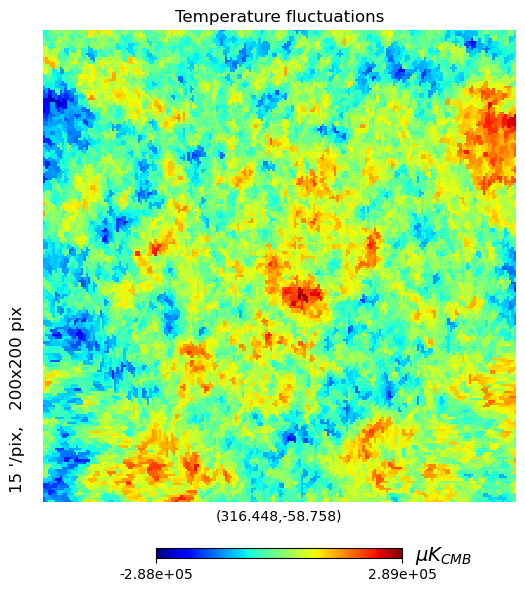

In [49]:
healpy_temp_fluctuations = np.zeros((hp.nside2npix(params['nside']), 3))
healpy_temp_fluctuations[..., 0] = atm.get_healpy_atm_maps_2d(atm.get_temp_maps(wv_fluctuations))[0]

index = np.where(healpy_temp_fluctuations!=0)[0]
healpy_temp_fluctuations[index, 0] -= np.mean(healpy_temp_fluctuations[index, 0])
min = np.min(healpy_temp_fluctuations[index, 0])
max = np.max(healpy_temp_fluctuations[index, 0])

hp.mollview(healpy_temp_fluctuations[..., 0], min=min, max=max, cmap='jet', title='Temperature fluctuations', unit=r'$µK_{CMB}$')
hp.gnomview(healpy_temp_fluctuations[..., 0], min=min, max=max, rot=equ2gal(0, -57), reso=15, cmap='jet', title='Temperature fluctuations', unit=r'$µK_{CMB}$')

In [8]:
print('Angular speed', qubic_dict['angspeed'])
print('Delta azimtuh', qubic_dict['delta_az'])
print('Sweeps per elevation', qubic_dict['nsweeps_per_elevation'])
print('Angular speed psi', qubic_dict['angspeed_psi'])
print('Maximum psi', qubic_dict['maxppsi'])
print('latitude', qubic_dict['latitude'])
print('longitude', qubic_dict['longitude'])
print('Fix_azimuth', qubic_dict['fix_azimuth'])
print('period', qubic_dict['period'])
print('duration', qubic_dict['duration'])
print('Observation date', qubic_dict['date_obs'], type(qubic_dict['date_obs']))

Angular speed 0.4
Delta azimtuh 20
Sweeps per elevation 1
Angular speed psi 0.1
Maximum psi None
latitude -24.183333333333334
longitude -66.46666666666667
Fix_azimuth {'apply': False, 'az': 50, 'el': 50, 'el_step': 1, 'fix_hwp': True, 'fix_pitch': True}
period 1
duration 20
Observation date 2016-01-01 00:00:00 <class 'str'>


# Scanning strategy

In [9]:
### Random pointing
qubic_dict['random_pointing'] = False

### Sweepingpointing
qubic_dict['sweeping_pointing'] = True
qubic_dict['fix_azimuth']['apply'] = False 
qubic_dict['duration'] = 1
qubic_dict['period'] = 9
qubic_dict['nsweeps_per_elevation'] = 1

### Repeat pointing
qubic_dict['repeat_pointing'] = False

q_sampling = get_pointing(qubic_dict)
print(q_sampling)

QubicSampling((400,), 
    index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 ,
    angle_hwp=[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 15. 15. 15. 15. 15. ,
    azimuth=[197.50277742 201.12264019 204.74247689 208.3622876  211.98207216,
    elevation=[49.13769317 49.13769317 49.13769317 49.13769317 49.13769317 49.1,
    equatorial=[[ 9.25107999e+00 -6.15234693e+01]
 [ 5.47283934e+00 -6.00594906e,
    galactic=[[305.97038237 -55.51954711]
 [309.64047467 -56.68225508]
 [313.4,
    masked=False,
    pitch=[-10.   -9.1  -8.2  -7.3  -6.4  -5.5  -4.6  -3.7  -2.8  -1.9  -1.)


Text(0, 0.5, 'Elevation (deg)')

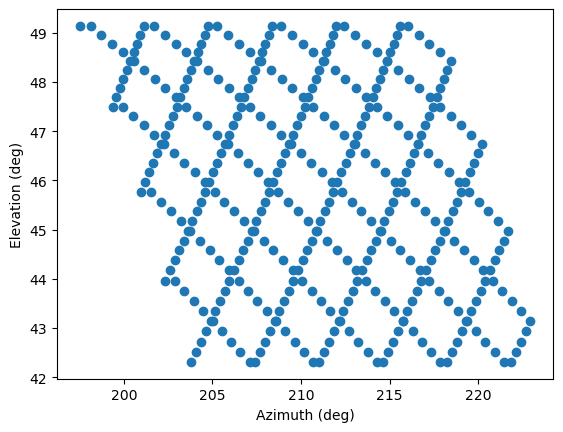

In [10]:
plt.plot(q_sampling.azimuth, q_sampling.elevation, 'o')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Elevation (deg)')

In [11]:
from pysimulators.interfaces.healpy import Spherical2HealpixOperator
from pysimulators import SphericalHorizontal2EquatorialOperator, SphericalEquatorial2GalacticOperator
from astropy.time import Time, TimeDelta

def _format_sphconv(a, b, date_obs=None, time=None):
    incoords = np.empty(np.broadcast(a, b).shape + (2,))
    incoords[..., 0] = a
    incoords[..., 1] = b
    if date_obs is None:
        return incoords
    time = Time(date_obs, scale='utc') + TimeDelta(time, format='sec')
    return incoords, time

incoords, time = _format_sphconv(q_sampling.azimuth, q_sampling.elevation, date_obs=qubic_dict['date_obs'], time=q_sampling.time)
h2e = SphericalHorizontal2EquatorialOperator(
        'NE', time, qubic_dict['latitude'], qubic_dict['longitude'], degrees=True)
e2g = SphericalEquatorial2GalacticOperator(degrees=True)
outcoords = e2g(h2e(incoords))

400


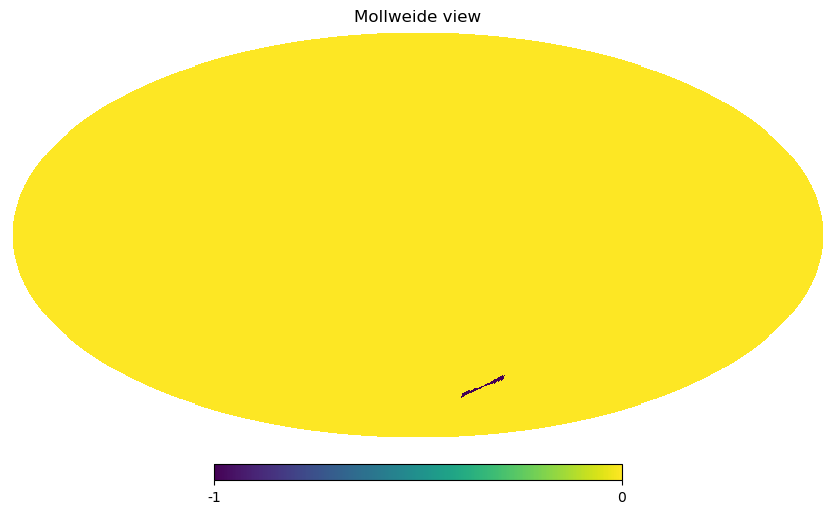

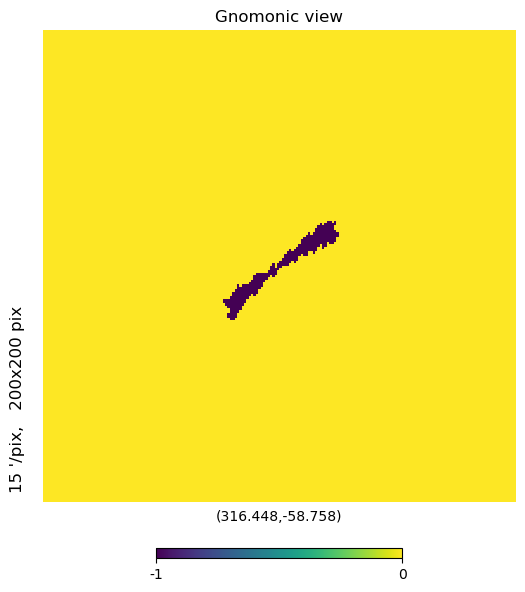

In [12]:
test = np.zeros(hp.nside2npix(params['nside']))
azel = np.asarray([q_sampling.azimuth, q_sampling.elevation]).T
index = np.array(Spherical2HealpixOperator(params['nside'], 'azimuth, elevation')(np.radians(outcoords)), dtype='int')
test[index] = -1
print(len(index))
hp.mollview(test)
hp.gnomview(test, rot=equ2gal(0, -57), reso=15)

# Wind

In [13]:
def random_wind(npointing, wind_mean, wind_std):
    wind_x = np.random.normal(wind_mean, wind_std, npointing)
    wind_y = np.random.normal(wind_mean, wind_std, npointing)
    
    return wind_x, wind_y

def constant_wind(npointing, wind_x, wind_y):
    ones = np.cumsum(np.ones(npointing))
    return wind_x*ones, wind_y*ones

def random_wind_corrected(npointing, wind_mean, wind_std):
    
    wind_x = np.cumsum(np.random.normal(wind_mean, wind_std, npointing))
    wind_y = np.cumsum(np.random.normal(wind_mean, wind_std, npointing))
    
    return wind_x, wind_y

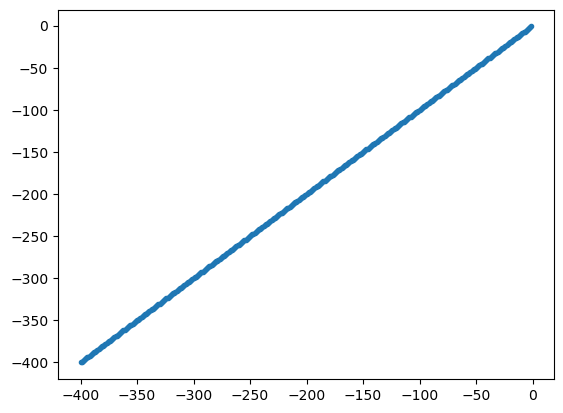

In [14]:
# wind_x, wind_y = random_wind_corrected(len(q_sampling.index), 0, 5)
wind_x, wind_y = constant_wind(len(q_sampling.index), -1, -1)

plt.plot(wind_x, wind_y, '.')

In [15]:
def azel_to_cartesian(azimuth, elevation, altitude):
    x = altitude / np.sin(elevation) * np.cos(elevation) * np.cos(azimuth)
    y = altitude / np.sin(elevation) * np.cos(elevation) * np.sin(azimuth)
    return x, y

def cartesian_to_azel(x, y ,altitude):
    r = np.sqrt(x**2 + y**2 + altitude**2)
    el = np.pi/2 - np.arccos(altitude/r)
    az = np.arctan2(y, x)
    return az, el

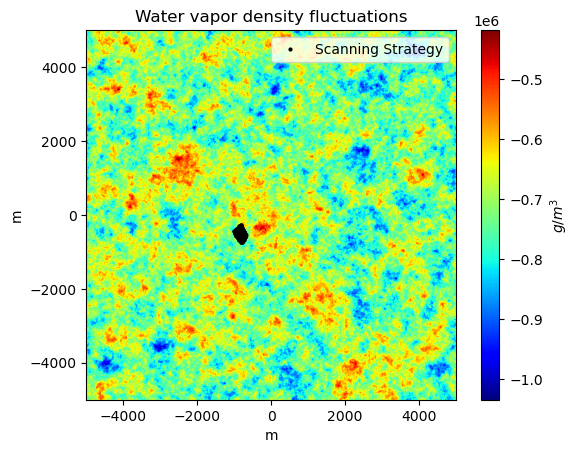

In [16]:
x, y = azel_to_cartesian(np.radians(q_sampling.azimuth), np.radians(q_sampling.elevation), params['altitude_atm_2d'])
plt.plot(x, y, 'ok', label='Scanning Strategy', markersize=2)
plt.imshow(temp_fluctuations[..., 0], cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.title('Water vapor density fluctuations')
plt.xlabel('m')
plt.ylabel('m')
plt.legend()
# plt.xlim(-1100, -600)
# plt.ylim(-800, -200)
plt.colorbar(label=r'$g/m^{3}$')

In [17]:
# Attention, il faut que j'ajoute le fait que le vent est en m/s, et qu'il y a du temps entre chaque point,
# pour pouvoir calculer correctement le décalage dû au vent

def get_deviation_index(position_x, position_y, wind_x, wind_y, delta_time):
    deviated_index_x = (np.round(wind_x) + np.round(position_x)).astype(int)
    deviated_index_y = (np.round(wind_y) + np.round(position_y)).astype(int)
    return deviated_index_x, deviated_index_y
delta_time = qubic_dict['duration']*3600/qubic_dict['period']
deviated_index_x, deviated_index_y = get_deviation_index(x, y, wind_x, wind_y, delta_time)

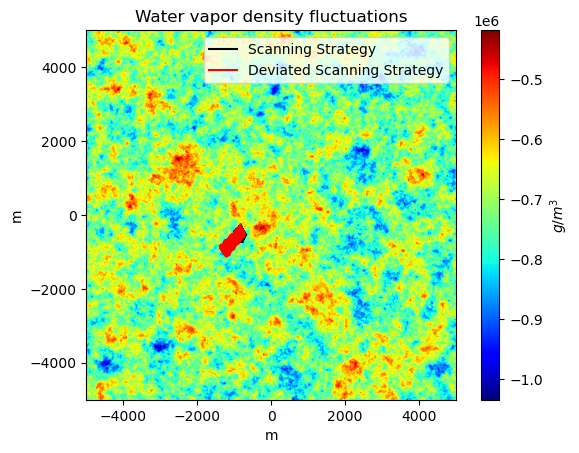

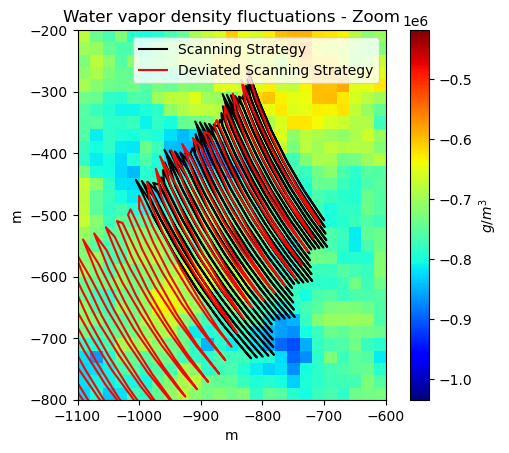

In [18]:
plt.figure()
plt.plot(x, y, 'k', label='Scanning Strategy', markersize=2)
plt.plot(deviated_index_x, deviated_index_y, 'r', label='Deviated Scanning Strategy', markersize=2)
plt.imshow(temp_fluctuations[..., 0], cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.title('Water vapor density fluctuations')
plt.xlabel('m')
plt.ylabel('m')
plt.legend()
plt.colorbar(label=r'$g/m^{3}$')

plt.figure()
plt.plot(x, y, 'k', label='Scanning Strategy', markersize=2)
plt.plot(deviated_index_x, deviated_index_y, 'r', label='Deviated Scanning Strategy', markersize=2)
plt.imshow(temp_fluctuations[..., 0], cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.title('Water vapor density fluctuations - Zoom')
plt.xlabel('m')
plt.ylabel('m')
plt.xlim(-1100, -600)
plt.ylim(-800, -200)
plt.legend()
plt.colorbar(label=r'$g/m^{3}$')

Text(0.5, 1.0, 'Scanning Strategy')

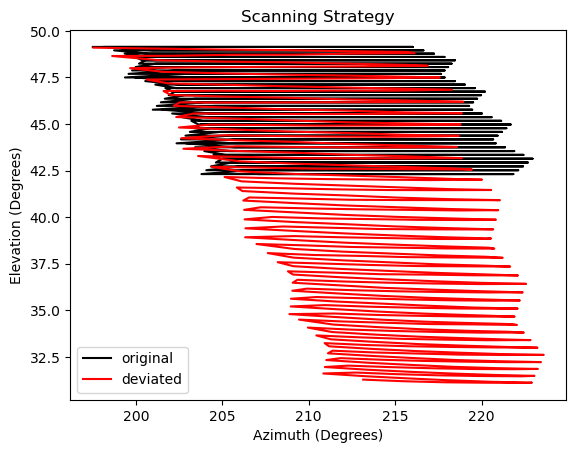

In [19]:
deviated_az, deviated_el = cartesian_to_azel(deviated_index_x, deviated_index_y, params['altitude_atm_2d'])

plt.plot(q_sampling.azimuth, q_sampling.elevation, 'k', label='original')
plt.plot(np.degrees(deviated_az%(2*np.pi)), np.degrees(deviated_el), 'r', label='deviated')
plt.xlabel('Azimuth (Degrees)')
plt.ylabel('Elevation (Degrees)')
plt.legend()
plt.title('Scanning Strategy')

# Create deviated Scanning Strategy 

In [20]:
q_sampling

QubicSampling((400,), 
    index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 ,
    angle_hwp=[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 15. 15. 15. 15. 15. ,
    azimuth=[197.50277742 201.12264019 204.74247689 208.3622876  211.98207216,
    elevation=[49.13769317 49.13769317 49.13769317 49.13769317 49.13769317 49.1,
    equatorial=[[ 9.25107999e+00 -6.15234693e+01]
 [ 5.47283934e+00 -6.00594906e,
    galactic=[[305.97038237 -55.51954711]
 [309.64047467 -56.68225508]
 [313.4,
    masked=False,
    pitch=[-10.   -9.1  -8.2  -7.3  -6.4  -5.5  -4.6  -3.7  -2.8  -1.9  -1.)

In [21]:
q_sampling_deviated = QubicSampling(azimuth=np.degrees(deviated_az%(2*np.pi)), elevation=np.degrees(deviated_el), pitch=q_sampling.pitch, 
                                    angle_hwp=q_sampling.angle_hwp, time=q_sampling.time, 
                                    period=q_sampling.period, latitude=q_sampling.latitude, longitude=q_sampling.longitude)

q_sampling_deviated.fix_az = q_sampling.fix_az

In [22]:
q_sampling_deviated

QubicSampling((400,), 
    index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 ,
    angle_hwp=[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 15. 15. 15. 15. 15. ,
    azimuth=[197.53552708 201.21290088 204.82577553 208.47910781 212.06806241,
    elevation=[49.09910282 49.04855227 48.99837512 48.96642611 48.90959372 48.8,
    equatorial=[[ 9.16768053e+00 -6.15426630e+01]
 [ 5.26588424e+00 -6.00874099e,
    galactic=[[306.03683691 -55.49647236]
 [309.8133672  -56.63317205]
 [313.6,
    masked=False,
    pitch=[-10.   -9.1  -8.2  -7.3  -6.4  -5.5  -4.6  -3.7  -2.8  -1.9  -1.,
    time=[   0.    9.   18.   27.   36.   45.   54.   63.   72.   81.   90)

# Build MM

In [23]:
q_instrument = QubicInstrument(qubic_dict)
q_scene = QubicScene(qubic_dict)

q_acquisition = QubicAcquisition(q_instrument, q_sampling, q_scene, qubic_dict)
q_acquisition_deviated = QubicAcquisition(q_instrument, q_sampling_deviated, q_scene, qubic_dict)

In [24]:
coverage = q_acquisition.get_coverage()

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

coverage_deviated = q_acquisition_deviated.get_coverage()

covnorm_deviated = coverage_deviated / coverage_deviated.max()
seenpix_deviated = covnorm_deviated > params['coverage_cut']

Info DESKTOP-5T6UOML: Allocating (396800,9) elements = 54.4921875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (396800,9) elements = 54.4921875 MiB in FSRRotation3dMatrix.__init__.


In [25]:
pointing_before_wind = test.copy()
pointing_after_wind = np.zeros(hp.nside2npix(params['nside']))
azel = np.asarray([q_sampling.azimuth, q_sampling.elevation]).T
index = np.array(Spherical2HealpixOperator(params['nside'], 'azimuth, elevation')(np.radians(outcoords)), dtype='int')
pointing_after_wind = np.zeros(hp.nside2npix(params['nside']))
pointing_after_wind[index] = 1

<Figure size 640x480 with 0 Axes>

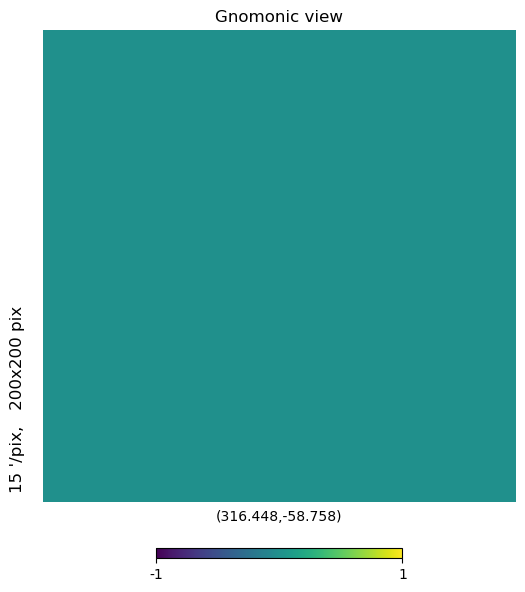

In [26]:
plt.figure()
hp.gnomview(pointing_before_wind + pointing_after_wind, rot=equ2gal(0, -57), reso=15, norm='hist')

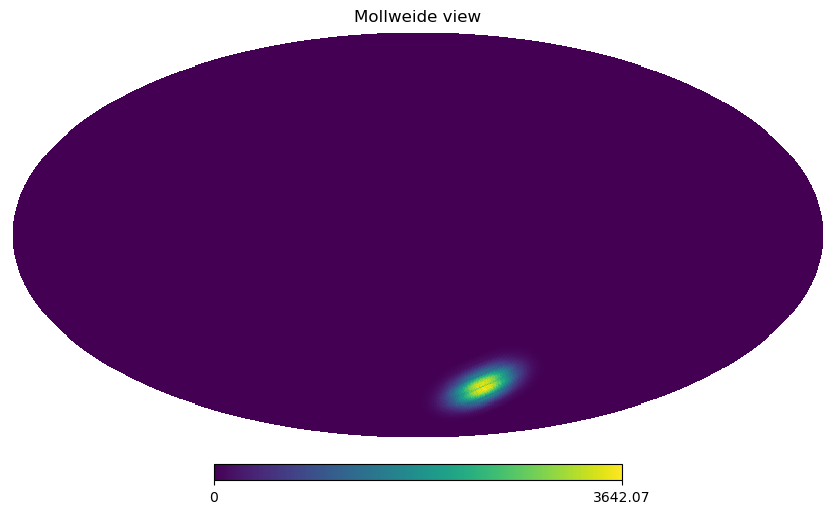

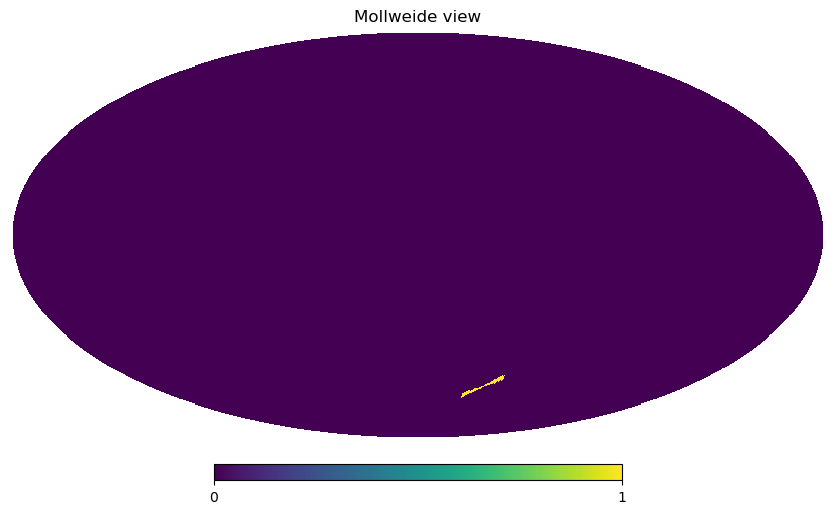

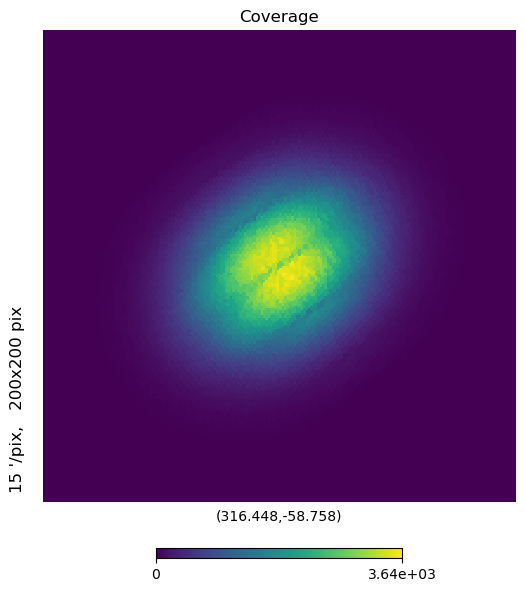

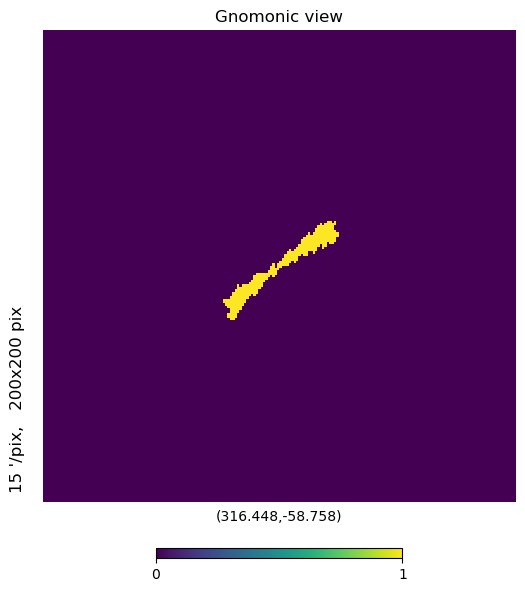

In [27]:
hp.mollview(coverage)
hp.mollview(pointing_after_wind)
hp.gnomview(coverage, rot=equ2gal(0, -57), reso=15, title='Coverage')
hp.gnomview(pointing_after_wind, rot=equ2gal(0, -57), reso=15)

In [28]:
H_qubic_deviated = q_acquisition_deviated.get_operator()
H_qubic = q_acquisition.get_operator()
R_qubic = ReshapeOperator(H_qubic.shapeout, H_qubic.shape[0])
invN_qubic = R_qubic(q_acquisition_deviated.get_invntt_operator(False, False)(R_qubic.T))
d_qubic = H_qubic_deviated(healpy_temp_fluctuations).ravel()

Info DESKTOP-5T6UOML: Allocating (396800,9) elements = 54.4921875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (396800,9) elements = 54.4921875 MiB in FSRRotation3dMatrix.__init__.


In [29]:
H = R_qubic(H_qubic)
invN = invN_qubic
d = d_qubic

In [30]:
A = H.T * invN * H
b = H.T * invN * d.flatten()
x0 = healpy_temp_fluctuations*0
true_maps = healpy_temp_fluctuations

In [31]:
stacked_dptdp_inv = np.zeros((1,12*params['nside']**2))

D = H.operands[2]
P = H.operands[-1]
sh = P.matrix.data.index.shape
no_det = 992
point_per_det = int(sh[0] / no_det)
mapPtP_perdet_seq = np.zeros((no_det, 12 * params['nside']**2))
sample_ranges = [(det * point_per_det, (det + 1) * point_per_det) for det in range(no_det)]
for det, (start, end) in enumerate(sample_ranges):
    indices = P.matrix.data.index[start:end, :]  
    weights = P.matrix.data.r11[start:end, :]
    flat_indices = indices.ravel()
    flat_weights = weights.ravel()

    mapPitPi = np.zeros(12 * params['nside']**2)
    np.add.at(mapPitPi, flat_indices, flat_weights**2)

    mapPtP_perdet_seq[det, :] = mapPitPi
D_elements = D.data
D_sq = D_elements**2
mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
dptdp = mapPtP_seq_scaled.sum(axis = 0)
dptdp_inv = 1 / dptdp
dptdp_inv[np.isinf(dptdp_inv)] = 0.
stacked_dptdp_inv[0] = dptdp_inv
M = BlockDiagonalOperator( \
            [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
            new_axisin=0)

# Map-Making

In [32]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=200,
    disp=True,
    M=M,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

 Iter     Tol      time
   1: 1.5170e-01 0.04830 [22574.37109864 13770.45958893  3955.81396698 ...  6901.93662792
 13864.85736767 39638.71674348]
   2: 9.4293e-02 0.03494 [18950.631025   15014.81879516  3727.22017194 ...  4660.14582871
  6914.04738825 34101.89269228]
   3: 6.5572e-02 0.03601 [15182.30389219 13967.80138027  4735.36560025 ... 11373.75763171
 10689.31849755 32755.92949607]
   4: 3.7873e-02 0.03585 [ 9609.5680153  12382.8484746   2960.08463957 ... 18236.76149225
 13749.21744562 27960.71713471]
   5: 3.8733e-02 0.03307 [ 8649.56542629 11294.37650436  4207.25771941 ... 21003.34840442
 17545.85023666 26117.06650948]
   6: 2.5967e-02 0.03975 [ 7164.57293025 12152.47958151  6871.83937617 ... 22405.17146294
 18333.96646886 25297.14252482]
   7: 2.5897e-02 0.03528 [ 6488.53470532 13272.69011993  7462.20584019 ... 24368.80127518
 20170.97939141 22684.05972948]
   8: 2.1212e-02 0.03435 [ 3616.19631989 16071.17982376  9035.01796596 ... 26214.96667113
 21015.07918922 22262.46904847]


Text(0, 0.5, 'Convergence')

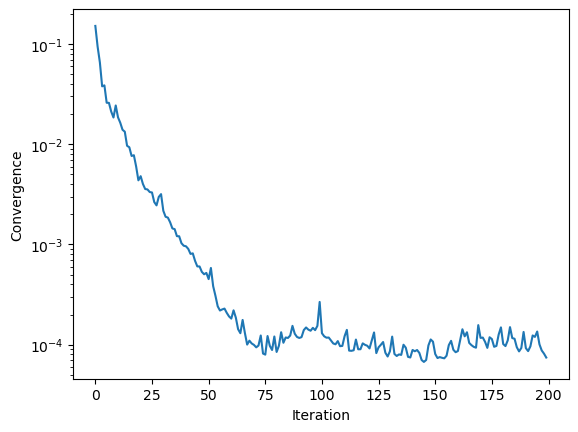

In [33]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

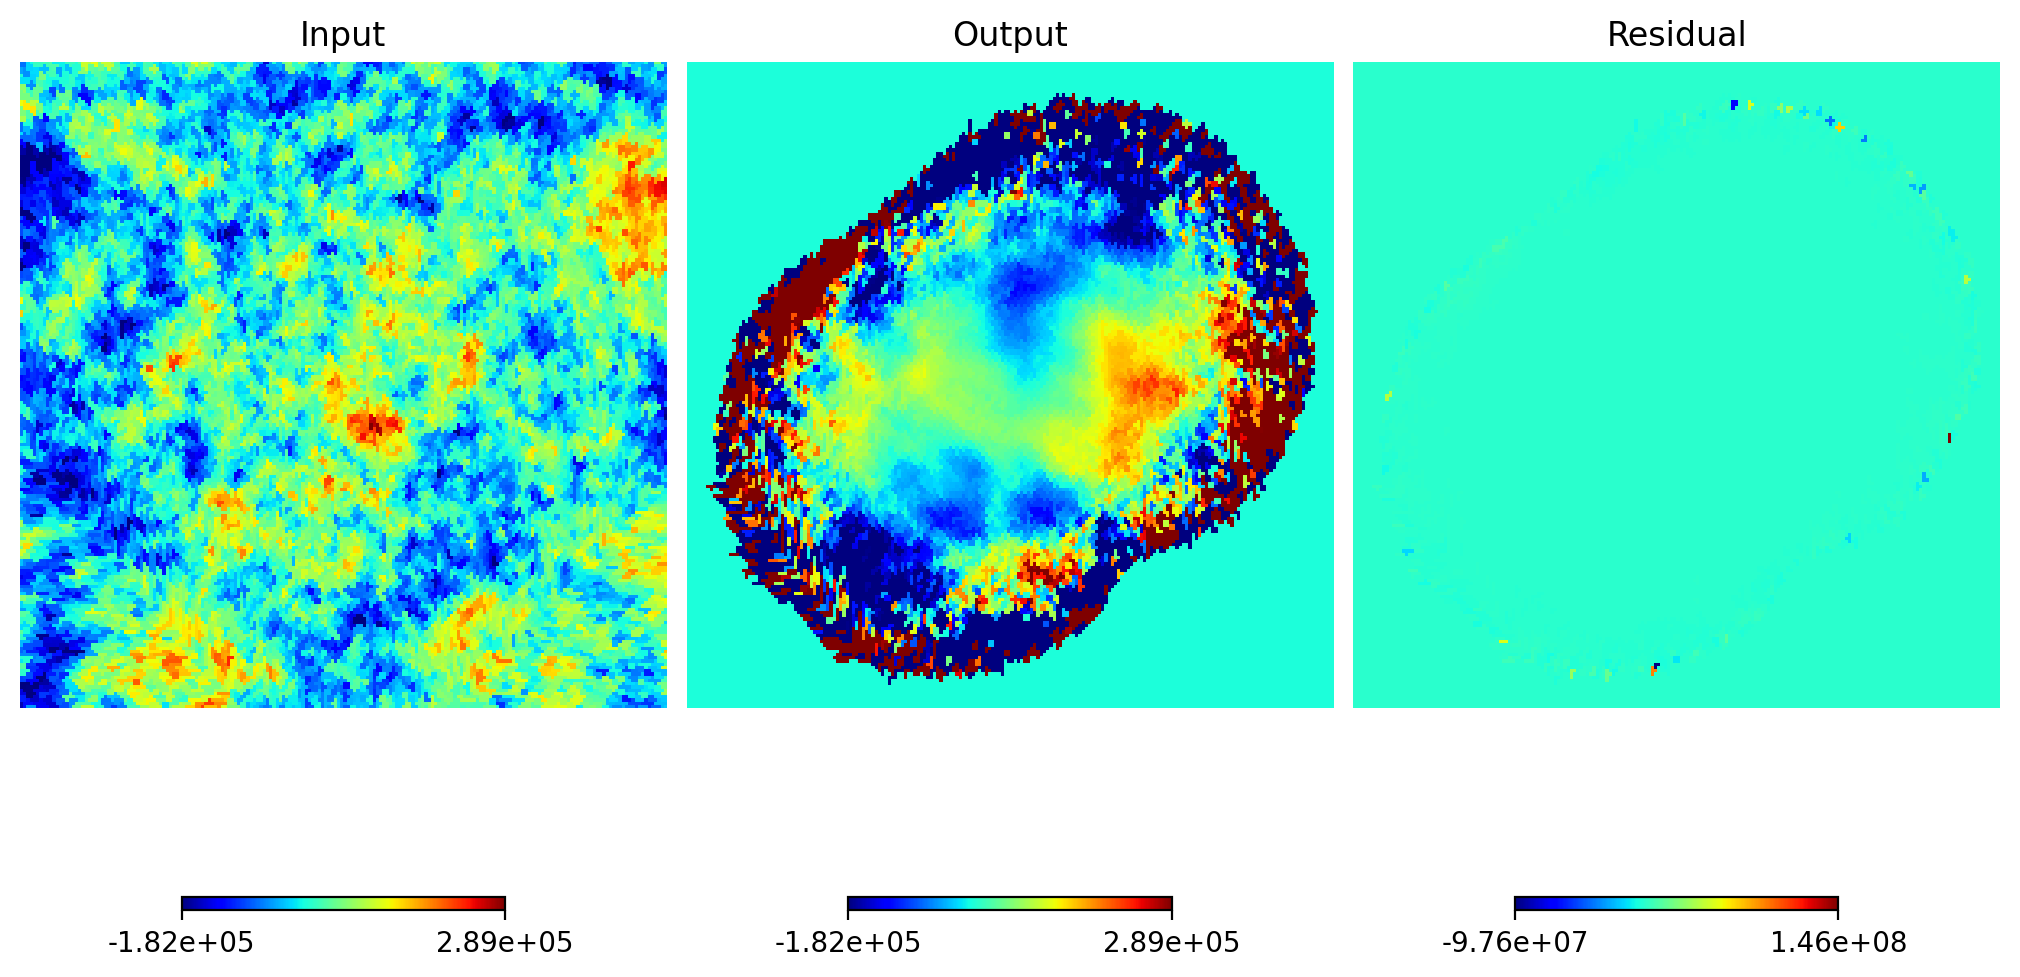

In [34]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
# true_maps[~seenpix, :] = hp.UNSEEN
# output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

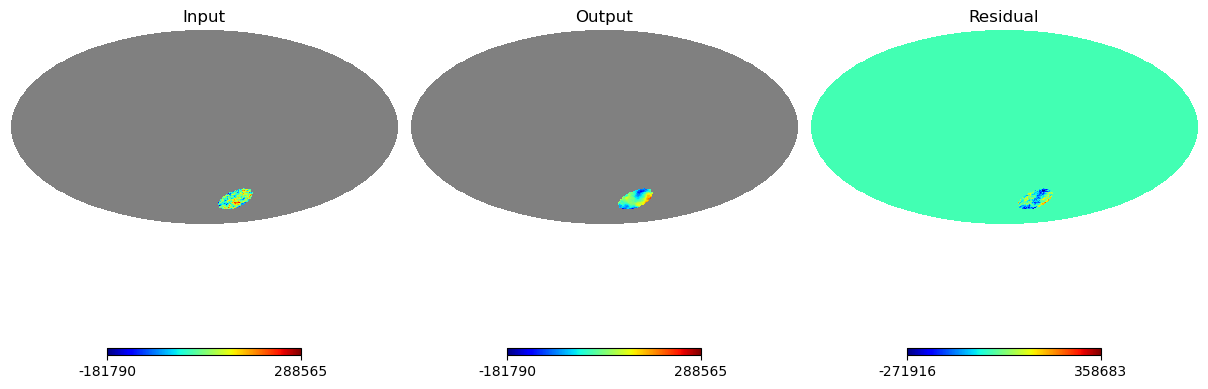

In [35]:
plt.figure(figsize=(12, 25))
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.mollview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k), title='Input', notext=True)
hp.mollview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k+1), title='Output', notext=True)
hp.mollview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

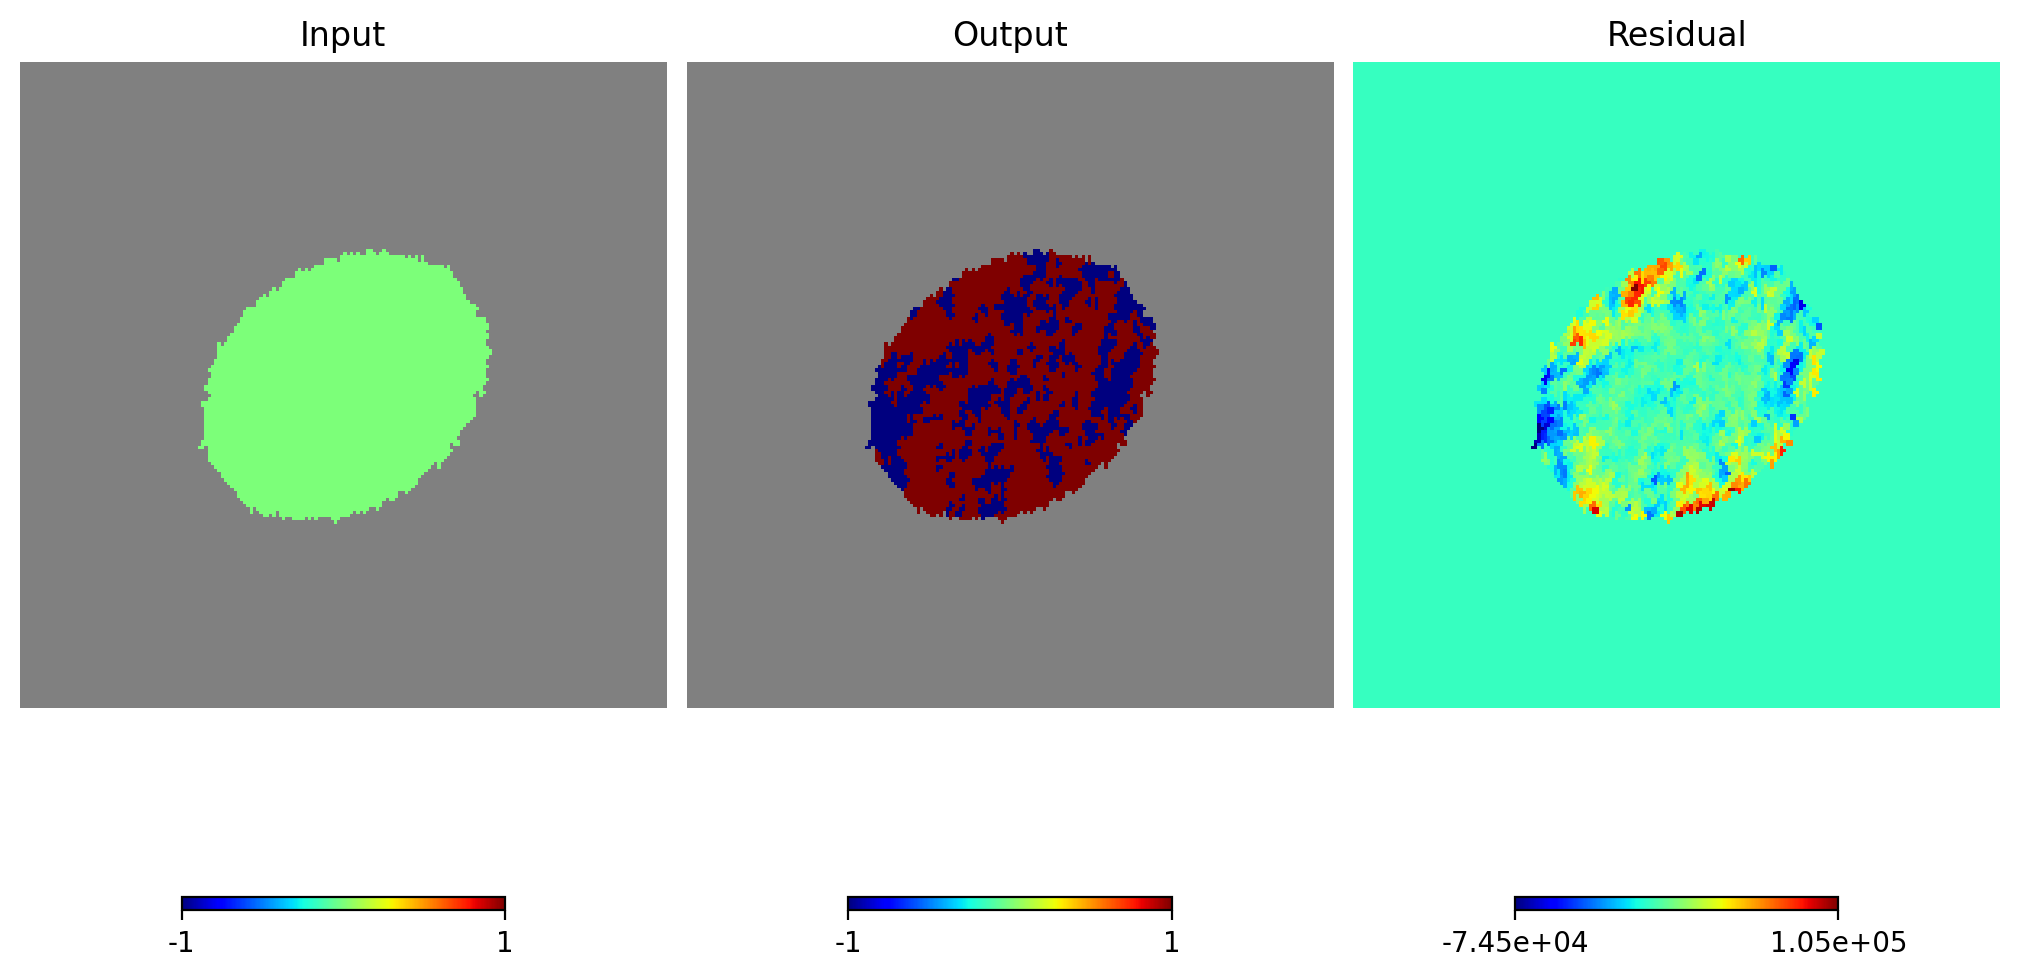

In [36]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3